Import all the libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Load the data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Sepsis Prediction/aggregated_data1.csv')


Initalizing dependants and target with train and test data

In [3]:
X = df.drop(columns=['SepsisLabel','Patient_ID'])
y = df['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Undersampling

In [4]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [5]:
print("After undersampling:")
print(pd.Series(y_train_res).value_counts())

After undersampling:
SepsisLabel
0    2086
1    2086
Name: count, dtype: int64


Training the model

In [6]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

Prediction

In [7]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

Classification Report

In [8]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     11255
           1       0.39      0.78      0.52       846

    accuracy                           0.90     12101
   macro avg       0.68      0.84      0.73     12101
weighted avg       0.94      0.90      0.91     12101

ROC-AUC: 0.9128017177550719


Confusion Matrix

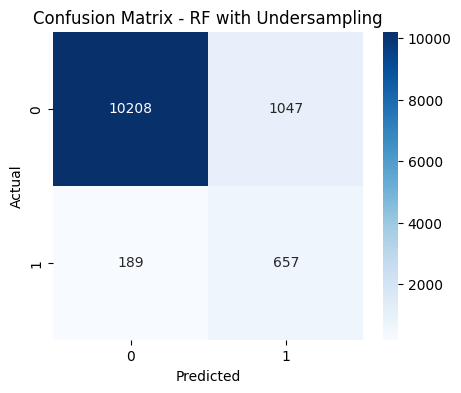

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RF with Undersampling')
plt.show()

Tuning hyperparameters

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Base RF model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

def run_grid_search(param_grid, X_train, y_train):
    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=2,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best ROC-AUC: {grid.best_score_}")
    return grid.best_estimator_


In [11]:
param_grid_depth = {'max_depth': [5, 10, 15, 20, None]}
best_rf = run_grid_search(param_grid_depth, X_train_res, y_train_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'max_depth': 15}
Best ROC-AUC: 0.9035302137848144


In [12]:
param_grid_split = {'min_samples_split': [2, 5, 10, 20]}
best_rf = run_grid_search(param_grid_split, X_train_res, y_train_res)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'min_samples_split': 20}
Best ROC-AUC: 0.9039869260632178


In [14]:
param_grid_leaf = {'min_samples_leaf': [1, 2, 4, 8]}
best_rf = run_grid_search(param_grid_leaf, X_train_res, y_train_res)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'min_samples_leaf': 8}
Best ROC-AUC: 0.9042168706116724


In [15]:
param_grid_features = {'max_features': ['sqrt', 'log2', None, 0.5]}
best_rf = run_grid_search(param_grid_features, X_train_res, y_train_res)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'max_features': None}
Best ROC-AUC: 0.9053950895349213


In [16]:
param_grid_weight = {'class_weight': [None, 'balanced', 'balanced_subsample']}
best_rf = run_grid_search(param_grid_weight, X_train_res, y_train_res)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'class_weight': 'balanced_subsample'}
Best ROC-AUC: 0.9027731161634819


In [17]:
param_grid_estimators = {'n_estimators': [100, 200, 500, 1000]}
best_rf = run_grid_search(param_grid_estimators, X_train_res, y_train_res)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'n_estimators': 1000}
Best ROC-AUC: 0.9056761229567574


Training the model with best parameters

In [18]:
from sklearn.ensemble import RandomForestClassifier

final_rf = RandomForestClassifier(
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=8,
    max_features=None,
    class_weight='balanced_subsample',
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=None, min_samples_leaf=8,
                       min_samples_split=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [19]:
y_pred = final_rf.predict(X_test)
y_pred_proba = final_rf.predict_proba(X_test)[:, 1]


In [20]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11255
           1       0.42      0.76      0.54       846

    accuracy                           0.91     12101
   macro avg       0.70      0.84      0.75     12101
weighted avg       0.94      0.91      0.92     12101

ROC-AUC Score: 0.9134


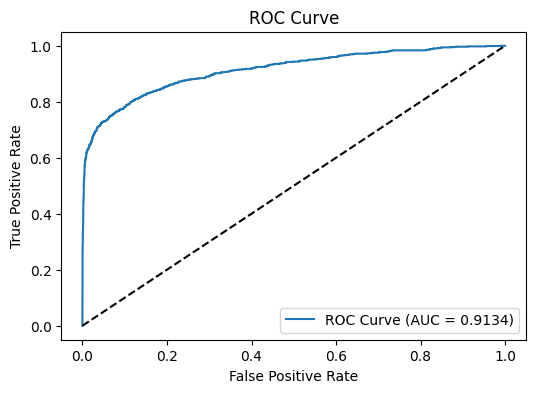

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


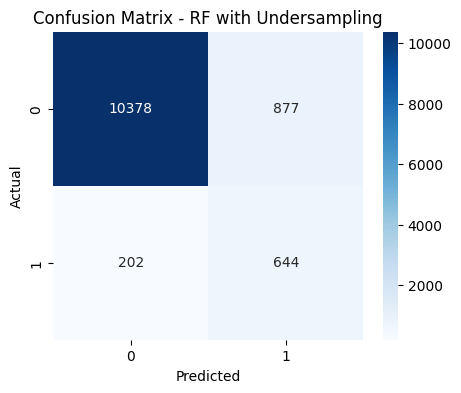

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RF with Undersampling')
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted probabilities
y_pred_proba = final_rf.predict_proba(X_test)[:, 1]

# Adjust threshold (lower than 0.5 to catch more positives)
threshold = 0.437 # try 0.4, 0.35, etc.
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate again
print(f"Classification Report (Threshold={threshold}):")
print(classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))


Classification Report (Threshold=0.437):
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     11255
           1       0.35      0.79      0.49       846

    accuracy                           0.88     12101
   macro avg       0.67      0.84      0.71     12101
weighted avg       0.94      0.88      0.90     12101

Confusion Matrix:
[[10013  1242]
 [  176   670]]


In [25]:

from sklearn.feature_selection import SelectFromModel


In [26]:
def add_engineered_features(df):
    df = df.copy()

    # Ratios
    if {'HR_mean', 'HR_min'}.issubset(df.columns):
        df['HR_mean_HR_min_ratio'] = df['HR_mean'] / (df['HR_min'] + 1e-6)

    if {'SpO2_mean', 'SpO2_min'}.issubset(df.columns):
        df['SpO2_mean_SpO2_min_ratio'] = df['SpO2_mean'] / (df['SpO2_min'] + 1e-6)

    if {'HR_mean', 'Age'}.issubset(df.columns):
        df['HR_mean_age_ratio'] = df['HR_mean'] / (df['Age'] + 1e-6)

    # Differences
    if {'HR_max', 'HR_min'}.issubset(df.columns):
        df['HR_range'] = df['HR_max'] - df['HR_min']

    if {'SpO2_max', 'SpO2_min'}.issubset(df.columns):
        df['SpO2_range'] = df['SpO2_max'] - df['SpO2_min']

    # Interaction
    if {'HR_mean', 'Resp_mean'}.issubset(df.columns):
        df['HR_Resp_interaction'] = df['HR_mean'] * df['Resp_mean']

    return df


In [27]:

df_eng = add_engineered_features(df)


In [58]:
X = df_eng.drop(columns=['SepsisLabel','Patient_ID'])
y = df_eng['SepsisLabel']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [60]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

Feature Selection

In [61]:
selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold="median")
selector.fit(X_train_res, y_train_res)

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

In [62]:
X_train_res_sel = selector.transform(X_train_res)
X_test_sel = selector.transform(X_test)

In [63]:
final_rf.fit(X_train_res_sel, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=None, min_samples_leaf=8,
                       min_samples_split=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [64]:
y_pred = final_rf.predict(X_test_sel)
y_proba = final_rf.predict_proba(X_test_sel)[:,1]

In [65]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     11221
           1       0.41      0.79      0.54       880

    accuracy                           0.90     12101
   macro avg       0.69      0.85      0.74     12101
weighted avg       0.94      0.90      0.91     12101

[[10202  1019]
 [  186   694]]
0.9162194870008344


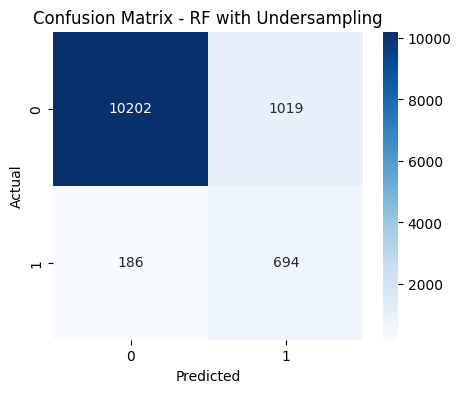

In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RF with Undersampling')
plt.show()

In [67]:
import joblib
joblib.dump(final_rf, "final_rf_model2.pkl")
from google.colab import files
files.download("final_rf_model2.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
import joblib

# Load your trained model
model = joblib.load("final_rf_model2.pkl")

# Check how many features the model expects
print("Number of features expected:", model.n_features_in_)


Number of features expected: 19


In [69]:
# Assuming you used SelectFromModel for feature selection
selected_features = X_train_res.columns[selector.get_support()]
print("Selected features used by the model:", list(selected_features))


Selected features used by the model: ['HR_std', 'O2Sat_mean', 'O2Sat_min', 'O2Sat_std', 'Temp_mean', 'Temp_min', 'Temp_max', 'Temp_std', 'SBP_mean', 'SBP_max', 'SBP_std', 'MAP_max', 'Resp_mean', 'Resp_min', 'Resp_std', 'ICULOS', 'HR_mean_HR_min_ratio', 'HR_range', 'HR_Resp_interaction']
